## Melanoma Assignment Problem Statement
 To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [2]:
!pip install -q -U keras-tuner
!pip install Augmentor

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.8 MB/s eta 0:00:00


In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
import PIL
import Augmentor
from keras_tuner import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

### Loading Data

In [4]:
!rm -rf /content/cancer_img
dataset_url = "https://drive.google.com/u/0/uc?id=1-gxPOBSlWP7S4zcNjE9iximvyDsjgxyz&export=download&confirm=t"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

823790659/823790659 [==============================] - 10s 0us/step


In [5]:
!mv  /root/.keras/datasets/'Skin cancer ISIC The International Skin Imaging Collaboration' /content/cancer_img
data_dir = pathlib.Path("/content/cancer_img").with_suffix('')

In [6]:
img_dir = list(data_dir.glob('*'))

In [7]:
# Assigning directory path of test and train

data_dir_train = img_dir[0]
data_dir_test = img_dir[1]

if img_dir[0].name in 'Test':
  data_dir_test = img_dir[0]
  data_dir_train = img_dir[1]

(data_dir_train,data_dir_test)

(PosixPath('/content/cancer_img/Train'), PosixPath('/content/cancer_img/Test'))

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train Image Count",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test Image Count",image_count_test)


Train Image Count 2239
Test Image Count 118


### Creating Train and validation dataset

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Found 2239 files belonging to 9 classes.
{'actinic keratosis': ['/content/cancer_img/Train/actinic keratosis/ISIC_0029133.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0029827.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0025803.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0030825.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0028941.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0027615.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0031993.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0028990.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0028370.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0029781.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0028393.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0030655.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0029500.jpg', '/content/cancer_img/Train/actinic keratosis/ISIC_0030133.jpg', '/content/cancer_img/Train/actinic kerat

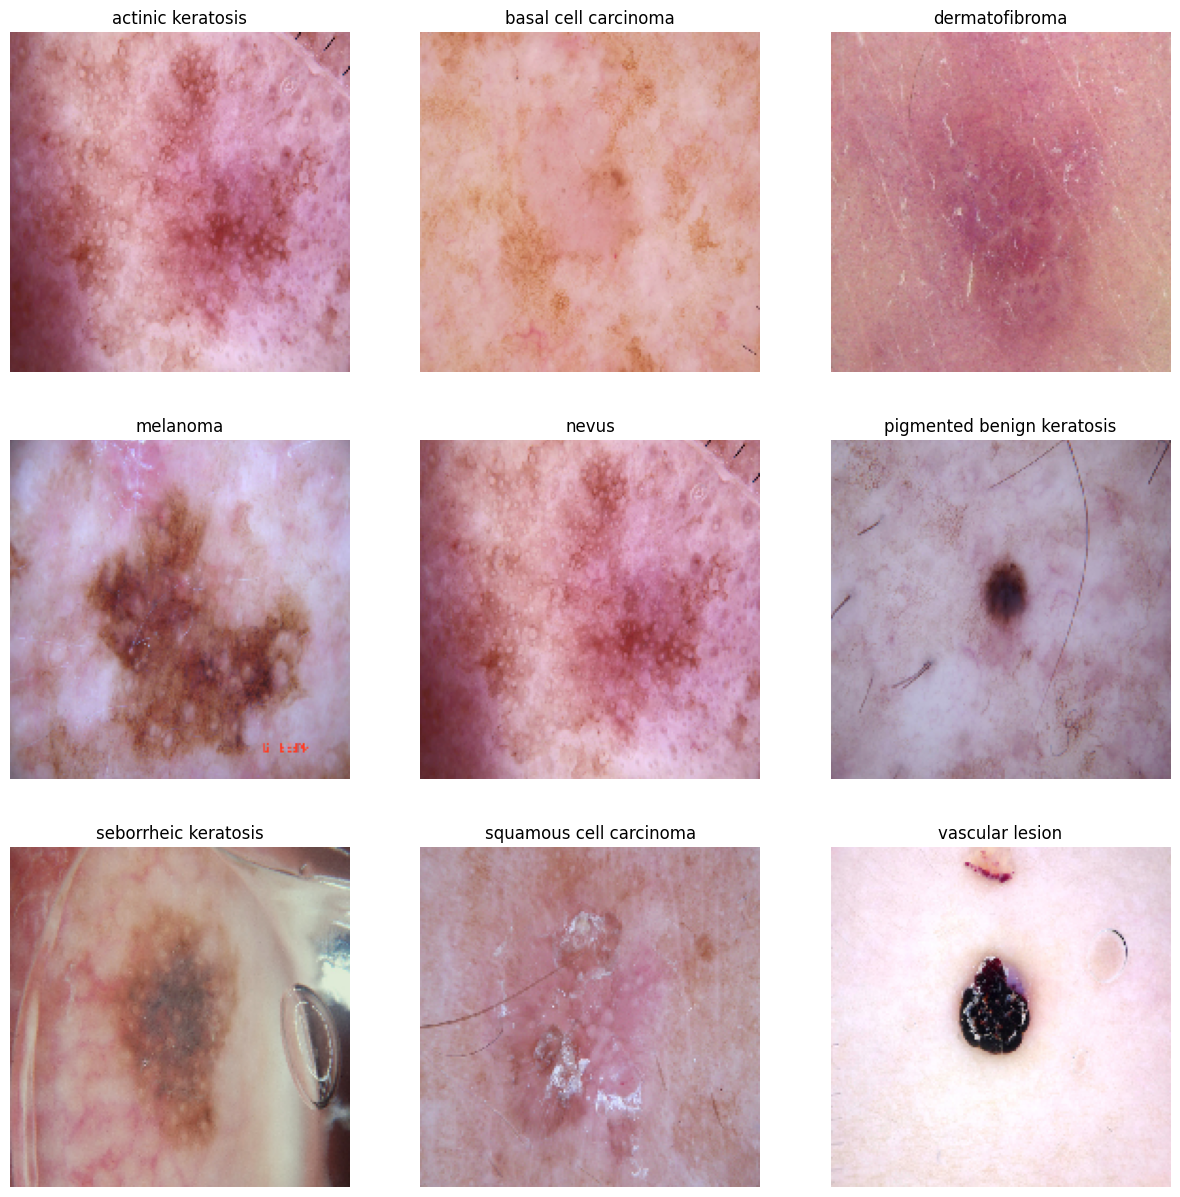

In [10]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

print(files_path_dict)
#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Creating model


In [13]:
class_names = train_ds.class_names
num_classes = len(class_names)
input_shape = (img_height,img_width,3)
(num_classes , input_shape )

(9, (180, 180, 3))

In [14]:
def execute_model(num_classes,mdl,train = train_ds, val =val_ds, optimizer='adam',loss='sparse_categorical_crossentropy',epochs=20):
  print("Settting Model Param for optimizer and loss \n")
  mdl.compile(
  optimizer=optimizer,
  loss=loss ,
  metrics=['accuracy'])

  mdl.summary()

  history = mdl.fit(
  train,
  validation_data=val,
  epochs=epochs
  )

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  #Evaluate the model on the validation dataset
  train_loss, train_accuracy = mdl.evaluate(train)
  val_loss, val_accuracy = mdl.evaluate(val)

  print("\n")
  print("Training Accuracy:", train_accuracy)
  print("Validation Accuracy:", val_accuracy)



#### Model 1: Naive Model

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

***Optimiser and Loss function for model training***

**Optimser** : They are responsible for updating the model's weights during training to minimize the loss function. The Adam is mostly used as it has the advantages of two other extensions of stochastic gradient descent (SGD), AdaGrad and RMSprop.

**Loss Function** : The problem statement is for multiclass classification problem , where each sample belong to one class hence chosing SparseCategoricalCrossentropy.

**Metric** : Accuracy is a commonly used metric for multiclass classification.

In [15]:
rescale_layer = tf.keras.Sequential([
  layers.Rescaling(1.0/255, input_shape=input_shape)
])

In [16]:
# Creating Model with 3 Convulation Layer
model = Sequential([
rescale_layer,
layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),

layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),

layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
layers.MaxPool2D(pool_size=(2,2)),

layers.Flatten(),

layers.Dense(128,activation='relu'),

layers.Dense(num_classes,activation='softmax')
])

Settting Model Param for optimizer and loss 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_

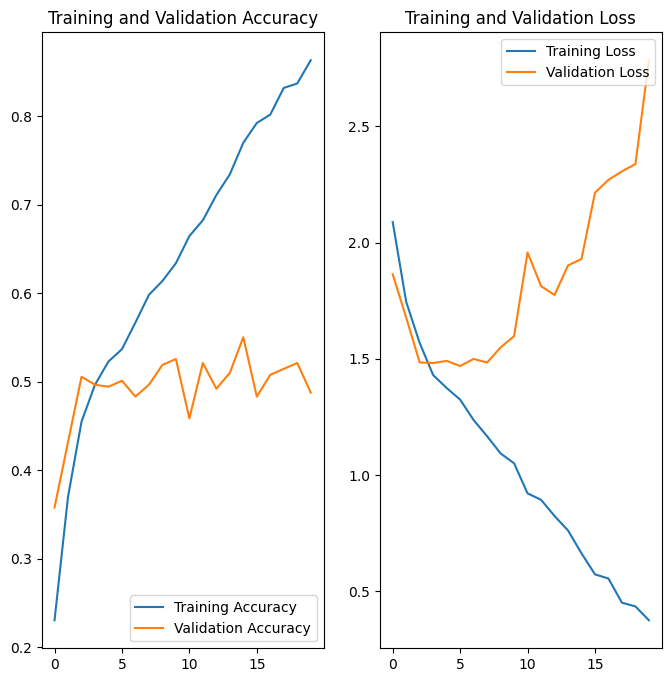

14/14 [==============================] - 1s 52ms/step - loss: 2.7849 - accuracy: 0.4877


Training Accuracy: 0.8755580186843872
Validation Accuracy: 0.48769575357437134


In [17]:
execute_model(num_classes,model,optimizer='adam',loss='sparse_categorical_crossentropy',epochs=20)

***Insight***

Model is Clearly Overfit , we can see the Training Accuracy keep rising, After epoch 5 we can see the validation starts falling or range bound below .55 to 0.48 range.
In the Loss Graph we can see that clearly , Loss increase a with increase in Epoch for training.

**Fix**: To address these problems, we will be augmenting the training data with transformations like rotations and flips can help improve data quality in the next model.Other techniques that can be applied are increasing model capacity, train longer, adjust learning rate and reduce regularization.

**Data augmentation** techniques generate different versions of a real dataset artificially to increase its size. Computer vision and natural language processing (NLP) models use data augmentation strategy to handle with data scarcity and insufficient data diversity.


#### Model 2 : Adding Augmentation Layer

In [18]:
data_augmentation_layer = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical",input_shape=input_shape),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomBrightness(factor=0.2),
  layers.RandomContrast(factor=0.2),
  layers.RandomTranslation(0.1, 0.1)
])

Lets check how image look after applying the data_augmentation_layer on the image.

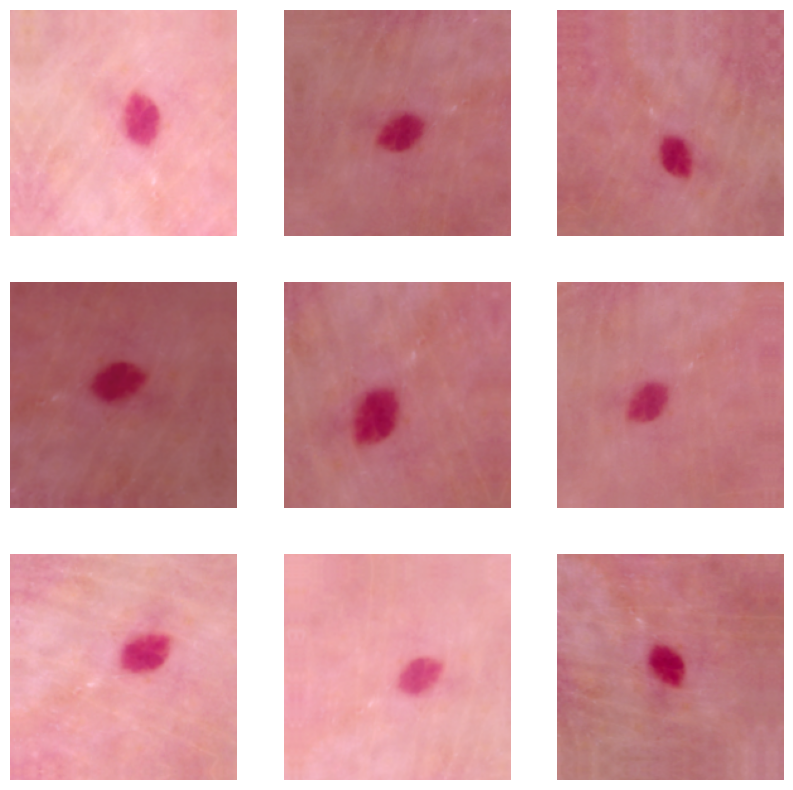

In [19]:
plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [20]:
model2 = Sequential([
    # Added  Augmentation Layer
    data_augmentation_layer,
    rescale_layer,

    layers.Conv2D(16,padding="same", kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Conv2D(32,padding="same",kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Conv2D(64,padding="same",kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Conv2D(128,padding="same",kernel_size=(3,3),activation='relu'),
    layers.MaxPool2D(pool_size=(2,2)),

    layers.Flatten(),

    layers.Dense(512,activation='relu'),
    layers.Dropout(0.20),
    layers.Dense(num_classes,activation='softmax')

])

Settting Model Param for optimizer and loss 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)    

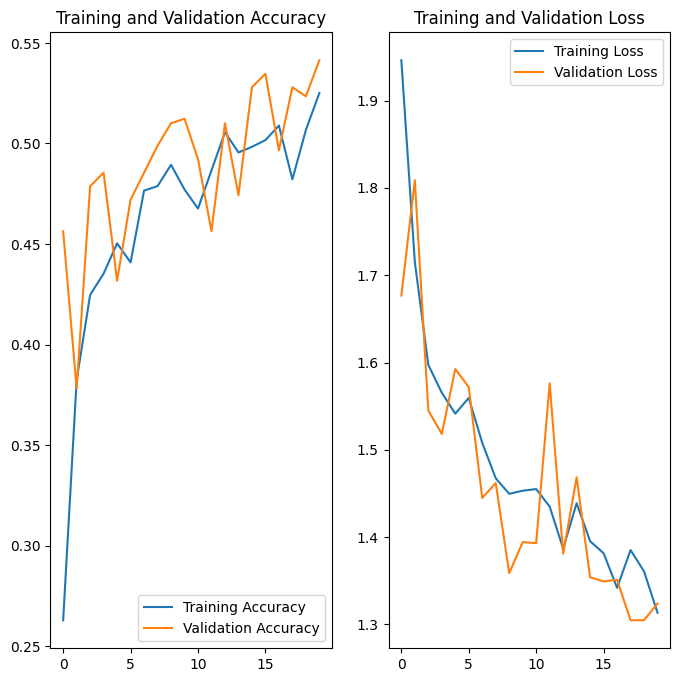

14/14 [==============================] - 1s 32ms/step - loss: 1.3240 - accuracy: 0.5414


Training Accuracy: 0.5625
Validation Accuracy: 0.5413870215415955


In [21]:
execute_model(num_classes, model2, optimizer='adam',epochs=20)

***Insight***

On Training data accuracy is 56% and on Validation data accuracy is 54%. although there is no overfitting the model is performing poorly. We have to check the distribution of the classes, if there is any imbalance in the sample of classes we will use augmentor to genrate samples.

By addressing class imbalance, we can improve the CNN model's ability to recognize and classify all classes effectively, leading to better overall performance and a more fair and unbiased classifier.

####  Distribution of classes in Train set

Here we are trying to figure out the Class distribution of the Tain Data.

In [22]:
class_map = {}
for k,v in files_path_dict.items():
  class_map[k]=len(v)
df = pd.DataFrame(list(class_map.items()),columns=['class','image_count'])
df

,class,image_count
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<Axes: xlabel='class', ylabel='image_count'>

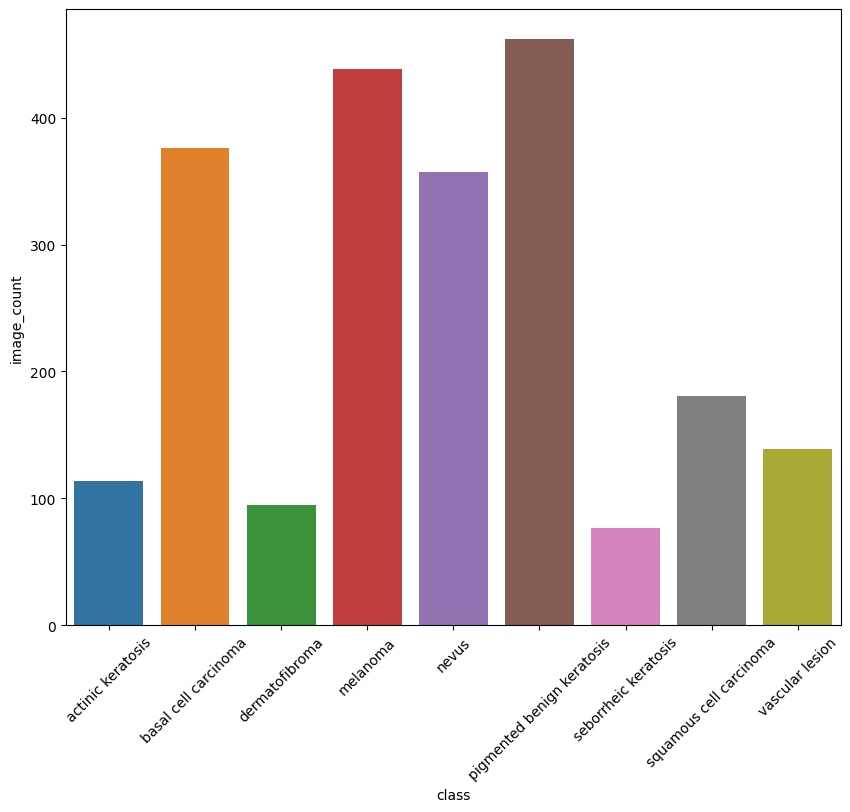

In [23]:
plt.figure(figsize=(10, 8))
plt.xticks(rotation=45)

sns.barplot(x="class", y="image_count", data=df,
            label="Classes")


*Insight*
* **seborrheic keratosis** class has the least amount of sample avaialble.
* **basal cell carcinoma, melanoma, pigmented benign keratosis, nevus**   classes has the highest amount of sample available

Q & A from the evaluation ?

- Which class has the least number of samples?
Seborrheic keratosis has the least number of samples

- Which classes dominate the data in terms proportionate number of samples?
The classes with the most number samples are:
    1.   pigmented benign keratosis
    2.   melanoma
    3.   basal cell carcinoma
    4.   nevus

 "pigmented benign keratosis" and "melanoma" has the largest sample set.

As we can see there is a class imbalance , Let *use* Augmentor Library to add 500 sample per class

#### Using Augmentor

In [24]:
for i in class_names:
    p = Augmentor.Pipeline(str(data_dir_train) +"/"+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/cancer_img/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCB046022F0>: 100%|██████████| 500/500 [00:01<00:00, 315.10 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/cancer_img/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCB4D7EA860>: 100%|██████████| 500/500 [00:01<00:00, 316.79 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/cancer_img/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCB046AB670>: 100%|██████████| 500/500 [00:01<00:00, 299.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/cancer_img/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCB4C5D28F0>: 100%|██████████| 500/500 [00:06<00:00, 78.88 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to /content/cancer_img/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7FCB4C66E350>: 100%|██████████| 500/500 [00:06<00:00, 82.51 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to /content/cancer_img/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCB4C31D720>: 100%|██████████| 500/500 [00:01<00:00, 319.33 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/cancer_img/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FCB4C2E9EA0>: 100%|██████████| 500/500 [00:02<00:00, 169.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/cancer_img/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FCB047BD6C0>: 100%|██████████| 500/500 [00:01<00:00, 316.20 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/cancer_img/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FCB24265E70>: 100%|██████████| 500/500 [00:01<00:00, 313.55 Samples/s]


In [25]:
for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Training Model After Augmenting

Reading the Data directory to create balance_train dataset & Validation dataset

In [27]:
balanced_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [28]:
balanced_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model with Augmentor

In [117]:
model3 = Sequential([
    data_augmentation_layer,
    rescale_layer,

    layers.Conv2D(32,padding="same", kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Conv2D(64,padding="same",kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Conv2D(128,padding="same",kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.5),


    layers.Flatten(),

    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(len(class_names),activation='softmax')
])


Settting Model Param for optimizer and loss 

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_30 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 sequential_28 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_94 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_93 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_88 (Bat  (None, 90, 90, 32)       128       
 chNormalization)                                                
                                                                 
 dropou

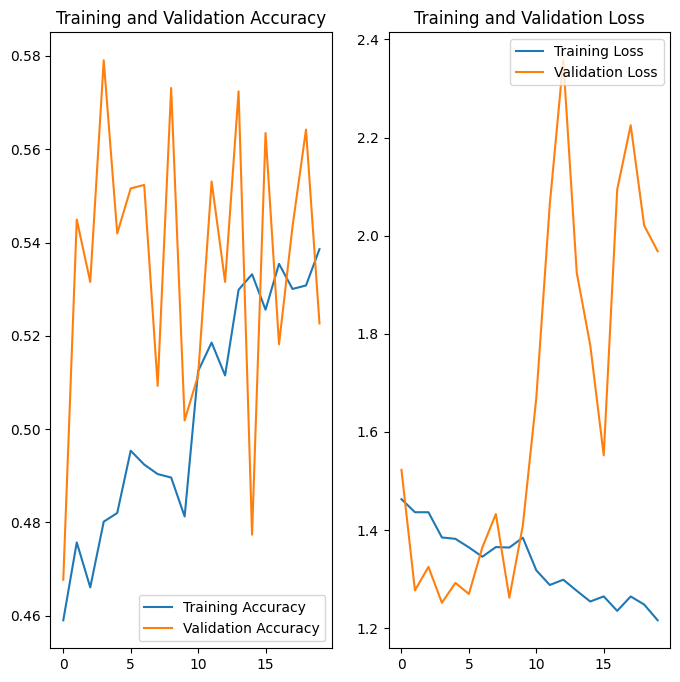

43/43 [==============================] - 3s 65ms/step - loss: 1.9683 - accuracy: 0.5226


Training Accuracy: 0.5196587443351746
Validation Accuracy: 0.5226429104804993


In [123]:
execute_model(num_classes,model3,train=balanced_train_ds,val=balanced_val_ds,optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),epochs=20)

**Insight**

We can see there is a linear increase in the training and validation accuracy. Loss is reducing with each epoch for both Training and validation. But, there seems to be large fluctuations in the validation loss and this can indicate that the CNN model is struggling to converge and find a stable solution

#### Model 4

Lets try to imporve the accuracy by removing one the Layer

In [41]:
model6 = Sequential([
    rescale_layer,

    layers.Conv2D(32,padding="same", kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Conv2D(64,padding="same",kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Conv2D(128,padding="same",kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),
    layers.Dropout(0.5),


    layers.Flatten(),

    layers.Dense(128,activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(len(class_names),activation='softmax')
])


Settting Model Param for optimizer and loss 

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_21 (Bat  (None, 90, 90, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_24 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_poo

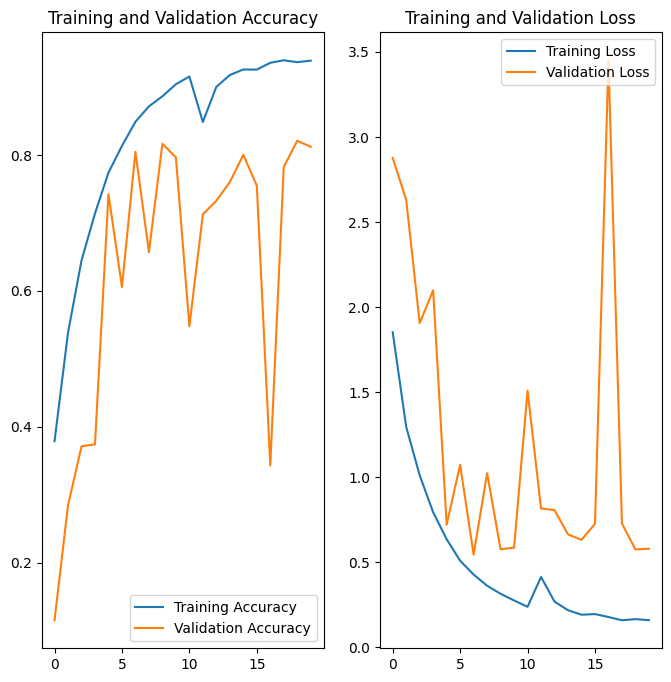

43/43 [==============================] - 3s 66ms/step - loss: 0.5797 - accuracy: 0.8122


Training Accuracy: 0.9543768763542175
Validation Accuracy: 0.8121752142906189


In [43]:
execute_model(num_classes,model6,train=balanced_train_ds,val=balanced_val_ds,optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),epochs=20)

**Insight**

There is a significant increase in the accuracy of training and validation. We can also see there is lot of fluctuation in accuracy and loss of validation



### Final  Observation on all the models after rebalancing


Did you get rid of underfitting/overfitting? Did class rebalance help?
The results with dataset augmentation have shown slight improvement over previous models.But, there seems to be large fluctuations in the validation loss and this can indicate that the CNN model is struggling to converge and find a stable solution. Such fluctuations can hinder the model's ability to generalize well to unseen data. Few steps to address the issues are - adjusting learning rate, consider larger batch size, consider early stopping, etc.

Yes rebalance helped in improving the accuracy